In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import os, re
import glob

from time import time
from scipy.io.arff import loadarff
from scipy import stats
from statsmodels.formula.api import ols, glm
from functools import reduce
import nltk                         
from nltk.tokenize import word_tokenize   
from nltk.corpus import stopwords         
from nltk.stem import WordNetLemmatizer    
from collections import Counter 
from wordcloud import STOPWORDS, WordCloud
import glob           
import konlpy
import json
import gensim

from konlpy.tag import Okt, Mecab
from collections import Counter
from wordcloud import WordCloud

import sklearn
import statsmodels
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow import keras

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !apt-get update
# !apt-get install g++ openjdk-8-jdk 
# !pip install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

# 1. IMDB 리뷰 데이터셋

In [5]:
from tensorflow.keras.datasets import imdb
(X_train, Y_train), (x_test, y_test) = imdb.load_data(num_words=500)

print(X_train.shape, x_test.shape)
print(Y_train.shape, y_test.shape)
print(len(X_train[1]))
print(X_train[0])
print('라벨: ', Y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

(25000,) (25000,)
(25000,) (25000,)
189
[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


239.00925 178.0


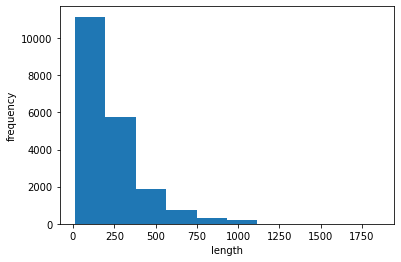

In [6]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

lengths = np.array([len(x) for x in x_train])
print(np.mean(lengths), np.median(lengths))

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train_pad = pad_sequences(x_train, maxlen=100)
x_val_pad = pad_sequences(x_val, maxlen=100)

print(x_train_pad.shape)
print()
print(x_train_pad[0])

(20000, 100)

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [8]:
# RNN(순환 신경망) 만들기

model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

train_ohe = keras.utils.to_categorical(x_train_pad)     # One-Hot Encoding
val_ohe = keras.utils.to_categorical(x_val_pad)

print(train_ohe.shape)
print(val_ohe.shape)
print()
print(train_ohe[0][0][:12])
print(np.sum(train_ohe[0][0]))
print()
model.summary()

(20000, 100, 500)
(5000, 100, 500)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1.0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
313/313 [==============================] - 10s 27ms/step - loss: 0.6962 - accuracy: 0.5113 - val_loss: 0.6926 - val_accuracy: 0.5146
Epoch 2/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6911 - accuracy: 0.5274 - val_loss: 0.6898 - val_accuracy: 0.5260
Epoch 3/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6873 - accuracy: 0.5465 - val_loss: 0.6863 - val_accuracy: 0.5412
Epoch 4/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6791 - accuracy: 0.5766 - val_loss: 0.6684 - val_accuracy: 0.6180
Epoch 5/100
313/313 [==============================] - 8s 26ms/step - loss: 0.6570 - accuracy: 0.6337 - val_loss: 0.6519 - val_accuracy: 0.6414
Epoch 6/100
313/313 [==============================] - 10s 31ms/step - loss: 0.6365 - accuracy: 0.6605 - val_loss: 0.6330 - val_accuracy: 0.6654
Epoch 7/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6184 - accuracy: 0.6816 - val_loss: 0.6125 - val_accurac

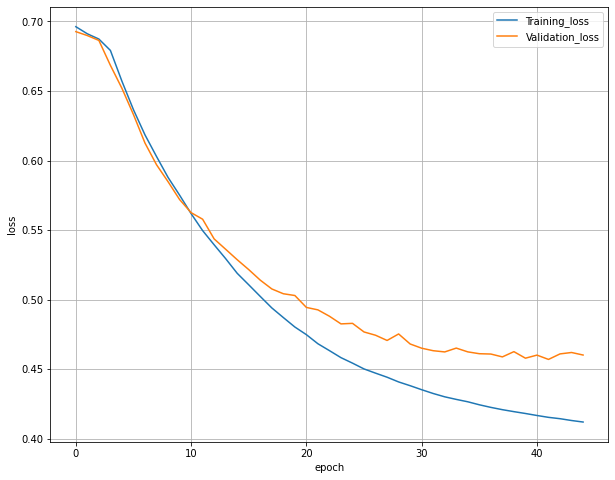

In [9]:
# RNN(순환 신경망) 훈련하기

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_ohe, y_train, epochs=100, batch_size=64, validation_data=(val_ohe, y_val), callbacks=[checkpoint_cb, early_stopping_cb])
                                          
plt.figure(figsize = (10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training_loss', 'Validation_loss'])
plt.grid(True)
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6951 - accuracy: 0.5095 - val_loss: 0.6882 - val_accuracy: 0.5388
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6716 - accuracy: 0.6047 - val_loss: 0.6609 - val_accuracy: 0.6452
Epoch 3/100
313/313 [=======

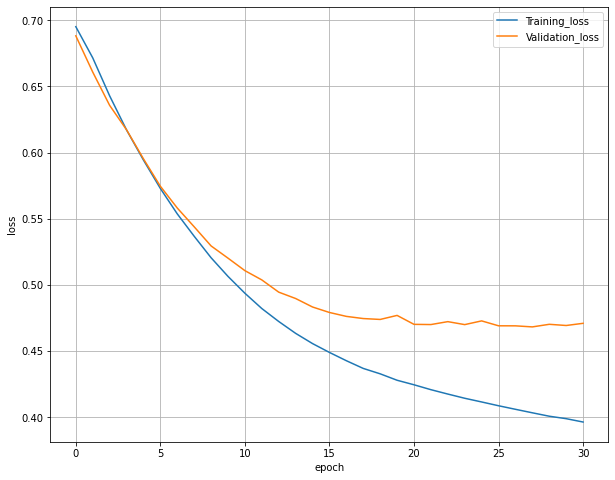

In [11]:
# 단어 임베딩 사용하기 : 원-핫 인코딩된 벡터보다 훨씬 의미있는 값으로 채워져 있기 때문에 자연어 처리에서 더 좋은 성능을 내는 경우가 많음

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))
model2.summary()

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(x_train_pad, y_train, epochs=100, batch_size=64, validation_data=(x_val_pad, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

plt.figure(figsize = (10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training_loss', 'Validation_loss'])
plt.grid(True)
plt.show()

# 2. Project_Sentiment_Analysis

네이버 영화리뷰 감성분석

### 1) 데이터 준비와 확인

In [12]:
train_data = pd.read_table('/content/drive/MyDrive/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/sentiment_classification/data/ratings_test.txt')

train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
test_data.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 2) 데이터로더 구성

- NaN 결측치 제거
- 데이터의 중복 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환

In [24]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 데이터 중복 제거
    train_data = train_data.dropna(how = 'any')                    # NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)  
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        x_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):  # word_to_index
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    return X_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index
    
X_train, Y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

In [25]:
# index_to_word

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2     # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력
print(word_to_index['영화']) # 5 가 출력
print(index_to_word[5])     # '영화' 가 출력

<BOS>
5
영화


In [26]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [28]:
print(X_train[0])           # 1번째 리뷰 데이터
print('라벨: ', Y_train[0])  # 1번째 리뷰 데이터의 라벨

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0


In [29]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', Y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [30]:
total_data_text = list(X_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens), 2)
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함된다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699 2
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함된다. 


In [31]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

print(X_train.shape, x_test.shape)

(146182, 41) (49157, 41)


### * RNN에서 padding 시 'pre' vs 'post' 

[1] https://biology-statistics-programming.tistory.com/42

### 4) 모델 구성 및 validation set 구성


In [33]:
vocab_size = 10000    # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# Model 설계
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.LSTM(8))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,809
Trainable params: 160,809
Non-trainable params: 0
_________________________________________________________________


In [34]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_val.shape)
print()
print(y_train.shape)
print(y_val.shape)

(116945, 41)
(29237, 41)

(116945,)
(29237,)


### 5) 모델 훈련

In [35]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
              
history = model3.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val), verbose=1)
history

Epoch 1/20
229/229 [==============================] - 7s 25ms/step - loss: 0.5219 - accuracy: 0.7691 - val_loss: 0.4017 - val_accuracy: 0.8358
Epoch 2/20
229/229 [==============================] - 5s 23ms/step - loss: 0.3652 - accuracy: 0.8477 - val_loss: 0.3657 - val_accuracy: 0.8469
Epoch 3/20
229/229 [==============================] - 5s 22ms/step - loss: 0.3294 - accuracy: 0.8642 - val_loss: 0.3571 - val_accuracy: 0.8488
Epoch 4/20
229/229 [==============================] - 5s 22ms/step - loss: 0.3108 - accuracy: 0.8736 - val_loss: 0.3556 - val_accuracy: 0.8489
Epoch 5/20
229/229 [==============================] - 6s 27ms/step - loss: 0.2985 - accuracy: 0.8789 - val_loss: 0.3558 - val_accuracy: 0.8492
Epoch 6/20
229/229 [==============================] - 5s 22ms/step - loss: 0.2884 - accuracy: 0.8850 - val_loss: 0.3572 - val_accuracy: 0.8484
Epoch 7/20
229/229 [==============================] - 5s 23ms/step - loss: 0.2790 - accuracy: 0.8890 - val_loss: 0.3603 - val_accuracy: 0.8485

#### * 테스트셋을 통한 모델 평가

In [36]:
results = model3.evaluate(x_test, y_test, verbose=1)
results

1537/1537 [==============================] - 4s 3ms/step - loss: 0.4452 - accuracy: 0.8373


[0.44518226385116577, 0.837317168712616]

In [37]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Accuracy 그래프 시각화

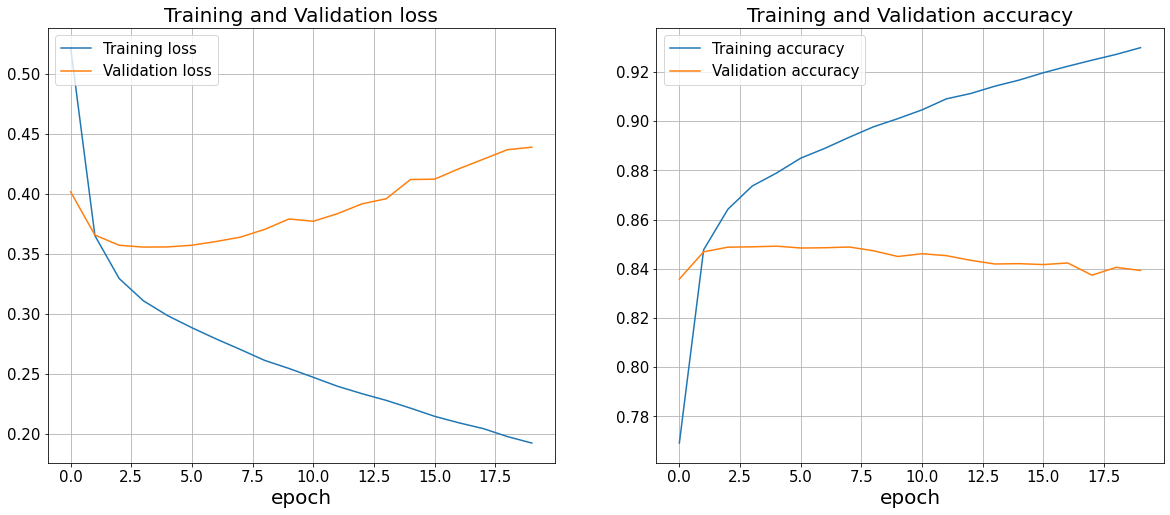

In [38]:
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Training loss', 'Validation loss'], loc='upper left', fontsize=15)
plt.grid(True)

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation accuracy', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left', fontsize=15)
plt.grid(True)

plt.show()

### 7) 학습된 Embedding 레이어 분석


In [39]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [40]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
f = open('/content/drive/MyDrive/sentiment_classification/data/word2vec.txt', 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model3.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format('/content/drive/MyDrive/sentiment_classification/data/word2vec.txt', binary=False)
vector = word_vectors['재미']
vector

array([-0.03950263, -0.09659826,  0.02103888,  0.3598713 , -0.07813616,
        0.01236501, -0.03816782,  0.02681365, -0.00491406,  0.02110501,
        0.06457398, -0.03393642, -0.193456  ,  0.0435188 , -0.06001086,
        0.03106483], dtype=float32)

In [42]:
word_vectors.similar_by_word("재미")

[('너무', 0.8935748934745789),
 ('완전', 0.8756329417228699),
 ('이렇게', 0.8334835767745972),
 ('정말', 0.8253175020217896),
 ('진짜', 0.8183951377868652),
 ('위해', 0.8048658967018127),
 ('수많', 0.7868239879608154),
 ('근본', 0.7731183767318726),
 ('의미', 0.767109215259552),
 ('귀한', 0.7651586532592773)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [43]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec = Word2VecKeyedVectors.load('/content/drive/MyDrive/sentiment_classification/data/word2vec_ko.model')
vector = word2vec.wv['사랑']
vector

array([ 3.2565942 , -0.85421413, -3.6964011 ,  1.0956469 ,  0.599815  ,
       -1.9681435 ,  0.32379073, -1.0716053 , -1.1776937 ,  2.0442047 ,
        2.2501915 , -2.7868037 , -2.702359  , -0.9775915 , -0.12478333,
        0.28235647,  0.77683175, -1.5393747 ,  2.0879042 , -5.444462  ,
       -4.931412  ,  0.8532094 ,  0.11118065, -2.743522  ,  0.7902363 ,
        0.10469969, -0.56074625,  1.6684421 ,  1.0278419 , -3.8816829 ,
       -3.606887  , -3.120771  , -1.2527398 , -0.77196646, -1.0102901 ,
        3.331668  ,  0.30032924,  1.2074511 , -1.2813627 ,  2.6281219 ,
       -1.4624823 , -1.1354805 ,  0.7605239 ,  2.83577   , -1.199358  ,
        3.1347232 ,  4.062026  , -0.23413125,  3.205856  , -0.9567054 ,
        0.77167803, -1.4300145 ,  2.9014013 , -3.940087  , -3.234169  ,
       -5.5460634 ,  0.6185009 , -0.75793767,  2.1043491 ,  2.350599  ,
        2.9313247 , -2.235593  ,  3.2084036 , -5.594638  ,  1.6516634 ,
       -0.32628602, -1.8824683 , -1.5573231 , -1.8452163 , -1.40

In [44]:
word2vec.similar_by_word("사랑")

<ipython-input-44-51be9db024eb>:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('이별', 0.7626415491104126),
 ('행복', 0.7550067901611328),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588401794434),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

#### * 이전 스텝에서 학습했던 모델의 임베딩 레이어를 word2vec으로 교체하여 다시 학습

In [47]:
vocab_size = 10000     # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

<ipython-input-47-5915424c45bf>:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
<ipython-input-47-5915424c45bf>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [48]:
vocab_size = 10000
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# Model 설계
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model4.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model4.add(keras.layers.LSTM(8, dropout=0.3))
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         3000000   
                                                                 
 lstm_1 (LSTM)               (None, None, 8)           9888      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,010,513
Trainable params: 3,010,513
Non-trainable params: 0
_________________________________________________________________


#### * 학습의 진행

Epoch 1/20
1828/1828 [==============================] - 79s 41ms/step - loss: 0.5545 - accuracy: 0.7475 - val_loss: 0.4427 - val_accuracy: 0.8103
Epoch 2/20
1828/1828 [==============================] - 79s 43ms/step - loss: 0.4106 - accuracy: 0.8244 - val_loss: 0.3881 - val_accuracy: 0.8366
Epoch 3/20
1828/1828 [==============================] - 84s 46ms/step - loss: 0.3753 - accuracy: 0.8385 - val_loss: 0.3701 - val_accuracy: 0.8418
Epoch 4/20
1828/1828 [==============================] - 74s 41ms/step - loss: 0.3599 - accuracy: 0.8467 - val_loss: 0.3611 - val_accuracy: 0.8463
Epoch 5/20
1828/1828 [==============================] - 76s 42ms/step - loss: 0.3500 - accuracy: 0.8505 - val_loss: 0.3552 - val_accuracy: 0.8481
Epoch 6/20
1828/1828 [==============================] - 76s 42ms/step - loss: 0.3433 - accuracy: 0.8531 - val_loss: 0.3509 - val_accuracy: 0.8504
Epoch 7/20
1828/1828 [==============================] - 74s 40ms/step - loss: 0.3366 - accuracy: 0.8562 - val_loss: 0.3470 -

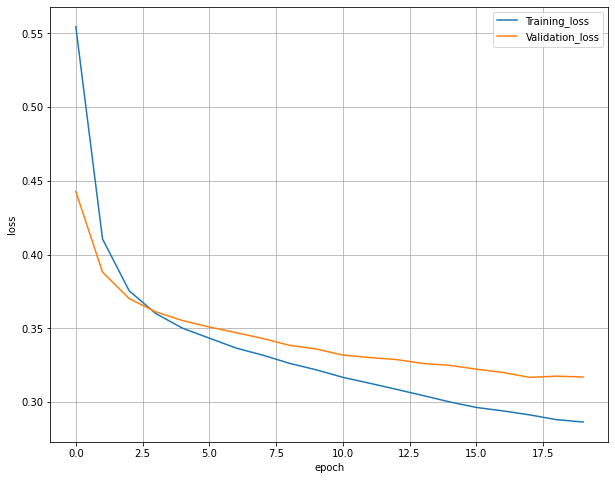

In [49]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')

history = model4.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val), verbose=1)

plt.figure(figsize = (10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training_loss', 'Validation_loss'])
plt.grid(True)
plt.show()

#### * 테스트셋을 통한 모델 평가

In [50]:
results = model4.evaluate(x_test, y_test, verbose=1)
results

1537/1537 [==============================] - 9s 6ms/step - loss: 0.3235 - accuracy: 0.8622


[0.323454886674881, 0.8621966242790222]

#### * Loss, Accuracy 그래프 시각화

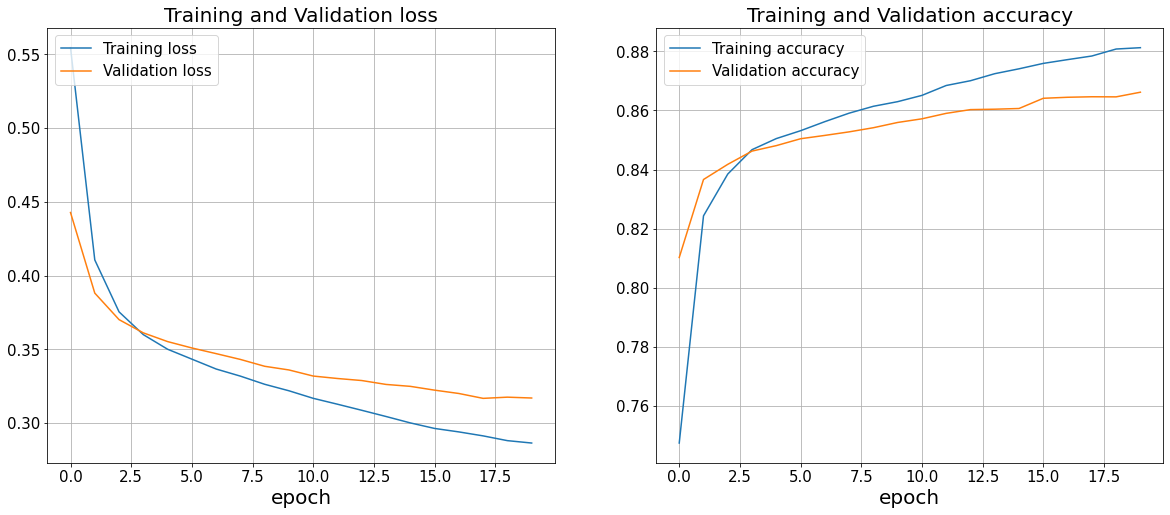

In [51]:
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Training loss', 'Validation loss'], loc='upper left', fontsize=15)
plt.grid(True)

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation accuracy', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left', fontsize=15)
plt.grid(True)

plt.show()

# 3. Conclusion


본 분석은 1. IMDB 리뷰 데이터셋 분석, 2. 네이버 영화리뷰 감성분석(프로젝트)의 두 단계로 진행된다.

1. 먼저, IMDB 리뷰 데이터셋은 인터넷 영화 데이터베이스인 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋으로 총 50,000개의 샘플이 훈련 데이터와 테스트 데이터에 각각 25,000개씩 나누어져 있다. IMDB 리뷰 데이터셋은 데이터를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리를 제공한다.


2. 이에 반해, 네이버 영화리뷰 감성분석에 사용할 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있으므로 먼저 imdb.data_loader()와 동일하게 동작하는 data_loader를 만들었다. 이후 데이터 준비와 확인 → 데이터로더 구성 → 모델 구성을 위한 데이터 분석 및 가공 → 모델 구성 및 훈련, 시각화 → 학습된 embeddig 레이어 분석 → 한국어 Word2Vec 임베딩 활용한 성능 개선 과정을 거쳤다.

   (1) 데이터 준비와 확인

   (2) 데이터로더 구성 - 결측치 제거, 데이터 중복 제거, 토큰화, 불용어 제거, word_to_index 구성, 텍스트 스트링을 사전 인덱스 스트링으로 변환

   (3) 모델 구성을 위한 데이터 분석 및 가공

   (4) 모델 구성 및 훈련, 시각화
 
    - 모델의 첫 번째 레이어는 Embedding 레이어로 vocab_size=10000(어휘 사전의 크기), word_vector_dim=16(워드 벡터 차원의 수)으로 설정하고, 고급 순환층인 LSTM을 사용하였으며, 특히 최종 출력은 긍정/부정을 나타내는 1dim을 사용하고 활성화 함수로 시그모이드 함수를 구성했다. 학습이 끝난 모델을 테스트셋으로 평가한 결과 accuracy=0.8373을 달성했다.

   (5) 학습된 embeddig 레이어 분석

    - '재미'라는 단어와 유사한 단어를 찾아본 결과 '너무', '완전', '이렇게' 등의 단어가 0.8935 ~ 0.7652의 정확도를 보였다. 하지만 감성 분석 태스크를 잠깐 학습한 것만으로는 워드 벡터가 유의미하게 학습되기는 어려우므로 word2vec.ko라는 사전학습된 워드 임베딩 모델을 추가로 활용했다. 

   (6) 한국어 Word2Vec 임베딩 활용하여 성능 개선

    - 모델은 총 5개의 층으로 구성되며 첫 번째 레이어인 Embedding 레이어에는 vocab_size = 10000, word_vector_dim = 300, LSTM 층에는 과대적합을 막기위해 dropout=0.3을 설정하였으며, 활성화 함수는 'relu', 'sigmoid'를 이용하고 최종 출력은 긍정/부정을 나타내는 1dim을 사용하였다. optimizer로 rmsprop 함수를 사용하였고, learning_rate은 기본값인 0.001이 아닌 0.0001, epoch=20, batch_size=64를 적용하였다.
그 결과 accuracy=0.8812, val_accuracy=0.8662가 도출 되었다.
테스트셋을 통한 모델 평가에서는 accuracy=0.8622를 달성하였다.
    
    - 사전학습된 word2vec 활용, 적절한 모델 구성, 하이퍼파라미터의 고려를 통해 모델의 성능이 약 2.49% 향상되어(accuracy=0.8373 → 
accuracy=0.8622) 네이버 영화리뷰 데이터 감성분석 정확도가 86.22%로 도출되었다.

# 4. References

[1] https://biology-statistics-programming.tistory.com/42

[2] https://lms.aiffel.io/course/382/node/504

[3] 혼자 공부하는 머신러닝+딥러닝